# WHY ARE CUSTOMERS CHURNING?

1. [Goals](#Goals)
1. [Questions](#Questions)
1. [Specification](#Specification)
1. [Deliverables](#Deliverables)
1. [Prepare the Environment](#Prepare-the-Environment)
1. [Acquistion](#Acquisition)
1. [Data Prep](#Data-Prep)
1. [Data Exploration](#Data-Exploration)
1. [Modeling](#Modeling)

**GOAL:**

- Why are our customers churning?

**Thoughts Going In:**
- There are features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.

- There is price threshold for specific services where the likelihood of churn increases once price for those services goes past that point. We will figure out the price point of where customers are churning

- Look at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, to see if those rates are comparable

**Deliverables:**

- a jupyter notebook where your work takes place
- a csv file that predicts churn for each customer
- a python script that prepares data such that it can be fed into your model
- a google slide summarizing your model
- a README.md file that contains a link to your google slides presentation, and instructions for how to use your python script(s)

## Prepare the Environment

In [425]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from pydataset import data

# Logistc Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# All modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

from env import host, user, password

## Acquisition

Here we will aquire the data from the ```customers``` table from the ```telco_churn``` database on the codeup data science database server using functions that we have created on the two attached csv files

In [28]:
def get_db_url(hostname: str, username: str, password: str, db_name: str) -> str:
    return f"mysql+pymysql://{username}:{password}@{hostname}/{db_name}"


def get_sql_conn(hostname: str, username: str, password: str, db_name: str):
    return create_engine(get_db_url(host, user, password, db_name))


def df_from_sql(query: str, url: str) -> pd.DataFrame:
    return pd.read_sql(query, url)


def get_telco_data() -> pd.DataFrame:
    db = "telco_churn"
    query = ("SELECT * "
             f"FROM customers;")
    url = get_db_url(host, user, password, db)
    return df_from_sql(query, url)

In [29]:
df = get_telco_data()

Let take a peek into what the dataframe looks like:
- Look at what the columns are
- Look at what the data within the columns mean
- Most columns are binary strings we might change them into integers later
- There are a number of features on this dataframe we need to look at how strongly correlated they are to churn

In [30]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,...,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,...,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes


**New Function:** ```peekatdata(dataframe)```, that takes a dataframe as input and computes and returns the following:
1. creates dataframe object ```head_df``` (df of the first 5 rows) and prints contents to screen
2. creates dataframe object ```tail_df``` (df of the last 5 rows) and prints contents to screen
3. creates tuple object ```shape_tuple``` (tuple of (nrows, ncols)) and prints tuple to screen
4. creates dataframe object ```describe_df``` (summary statistics of all numeric variables) and prints contents to screen.
5. prints to screen the information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [31]:
def peekatdata(dataframe):
    head_df = dataframe.head()
    print(f"HEAD\n{head_df}", end="\n\n")

    tail_df = dataframe.tail()
    print(f"TAIL\n{tail_df}", end="\n\n")

    shape_tuple = dataframe.shape
    print(f"SHAPE: {shape_tuple}", end="\n\n")

    describe_df = dataframe.describe()
    print(f"DESCRIPTION\n{describe_df}", end="\n\n")

    print(f"INFORMATION")
    dataframe.info()

In [32]:
peekatdata(df)

HEAD
  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines  internet_service_type_id online_security  \
0           Yes             No                         1              No   
1           Yes            Yes                         1              No   
2           Yes             No                         2              No   
3           Yes             No                         2              No   
4           Yes             No                         2              No   

   ...  device_protection tech_support streaming_tv streaming_movies  \
0  ...                 No          Yes          Yes      

## Data Preparation

**New Function:** ```df_value_counts(dataframe)```
1. takes a dataframe as input and computes and returns the values by frequency for each column. 
2. The function decides whether or not to bin the data for the value counts.

In [426]:
def df_value_counts(dataframe):
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f"{col}:")
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False))
        else:
            print(df[col].value_counts())
        print("\n")

In [34]:
df_value_counts(df)

customer_id:
8204-YJCLA    1
7733-UDMTP    1
6360-SVNWV    1
4568-TTZRT    1
2606-RMDHZ    1
7029-IJEJK    1
6110-OHIHY    1
9822-BIIGN    1
2410-CIYFZ    1
1496-GGSUK    1
6112-KTHFQ    1
7272-QDCKA    1
2804-ETQDK    1
0512-FLFDW    1
1763-WQFUK    1
9391-LMANN    1
5788-YPOEG    1
2809-ILCYT    1
3258-ZKPAI    1
3936-QQFLL    1
1360-XFJMR    1
6169-PGNCD    1
1752-OZXFY    1
8059-UDZFY    1
3908-BLSYF    1
0565-JUPYD    1
2528-HFYZX    1
7748-UMTRK    1
2252-ISRNH    1
4803-AXVYP    1
9592-ERDKV    1
5956-YHHRX    1
3312-ZWLGF    1
9927-DSWDF    1
3654-ARMGP    1
1077-HUUJM    1
9553-DLCLU    1
0329-GTIAJ    1
5360-XGYAZ    1
8711-LOBKY    1
8746-OQQRW    1
6736-DHUQI    1
6203-HBZPA    1
1231-YNDEK    1
3663-MITLP    1
4911-BANWH    1
8610-ZIKJJ    1
7826-VVKWT    1
4767-HZZHQ    1
8623-ULFNQ    1
7541-YLXCL    1
1987-AUELQ    1
1729-VLAZJ    1
9788-YTFGE    1
1271-SJBGZ    1
1092-GANHU    1
5515-RUGKN    1
6032-KRXXO    1
5924-SNGKP    1
9168-INPSZ    1
1689-YQBYY    1
4737-HOBAX 

**This is a TON of information to look at**
1. We will explore the data and see if there are any missing values.
2. Write a function that accepts a dataframe and returns the names of the columns that have missing values, and the percent of missing values in each column that has missing values.
3. Determine that we should just remove the 11 rows with the missing date
4. We are going to keep total_charges as a variable and use it in our model
5. No need to determine if the missing equivalent to 0 (or some other constant value) in the specific case of this variable?
6. We will again just remove the rows all together since 11 rows will not make a significant impact in our model


In [35]:
df['total_charges'] = df['total_charges'].replace(r'\s+', np.nan, regex=True)
df.isnull().sum()

customer_id                  0
gender                       0
senior_citizen               0
partner                      0
dependents                   0
tenure                       0
phone_service                0
multiple_lines               0
internet_service_type_id     0
online_security              0
online_backup                0
device_protection            0
tech_support                 0
streaming_tv                 0
streaming_movies             0
contract_type_id             0
paperless_billing            0
payment_type_id              0
monthly_charges              0
total_charges               11
churn                        0
dtype: int64

In [36]:
df = df.fillna(0)
df.isnull().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
dtype: int64

**Transform ```churn```** such that "yes" = 1 and "no" = 0 using sklearn LabelEncoder

In [37]:
encoder = LabelEncoder()

encoder.fit(df.churn)
df.churn = encoder.transform(df.churn)

In [38]:
df.churn.value_counts(dropna=False)

0    5174
1    1869
Name: churn, dtype: int64

### Creating New variables to use later in our model

**NEW variable** tenure year*
    tenure_year will calculate how many years of tenure based on the number of months

In [39]:
df[['tenure_year']] = df[['tenure']]/12

**NEW variable** _'phone id'_
    0 = Does phone service
    1 = Has one phone line
    2 = Has multiple lines

In [40]:
df['phone_id'] = df['phone_service'].map(str) + df['multiple_lines']
df['phone_id'] = df['phone_id'].replace({'NoNo phone service': 0, 'YesNo': 1, 'YesYes': 2})

**NEW variable** _'household type id'_
    0 = Does not have a dependent or a partner
    1 = Only has a dependent
    2 = Only has a partner
    3 = Has BOTH a dependent and a partner

In [41]:
df['household_type_id'] = df['dependents'].map(str) + df['partner']
df['household_type_id'] = df['household_type_id'].replace({'NoNo': 0, 'NoYes': 1, 'YesNo': 2, 'YesYes': 3})

**NEW variable** _'streaming services'_
    0 = Does not have streaming services
    1 = Only Movie Streaming Services
    2 = Only TV Streaming Services
    3 = Has BOTH Movie and TV Streaming Services

In [42]:
df['streaming_services'] = df['streaming_tv'].map(str) + df['streaming_movies']
df['streaming_services'] = df['streaming_services'].replace({'NoNo': 0, 'NoYes': 1, 'YesNo': 2, 'YesYes': 3})

**NEW variable** _'online security backup'_
    0 = Does not have online security or backup
    1 = Only has online security
    2 = Only has online backup
    3 = Has BOTH online security and online backup

In [43]:
df['online_security_backup'] = df['online_security'].map(str) + df['online_backup']
df['online_security_backup'] = df['online_security_backup'].replace({'NoNo': 0, 'NoYes': 1, 'YesNo': 2, 'YesYes': 3, 'No internet serviceNo internet service': 4})

**Split the data into train (70%) & test (30%) samples**
- We will use the training data to produce any number of classification models
- In the end we will select the model that we think works the best and run the model against the out of sample data
- Finally we will produce a csv file with the outcome of the test

In [343]:
train_df, test_df = train_test_split(df, test_size=.30, random_state=123, stratify=df[['churn']])

In [344]:
cols_to_remove = ['phone_service', 'multiple_lines', 'dependents', 'partner', 'streaming_tv', 'streaming_movies',
                  'online_security', 'online_backup']

train_df = train_df.drop(cols_to_remove, axis=1)
train_df.columns.values

array(['customer_id', 'gender', 'senior_citizen', 'tenure',
       'internet_service_type_id', 'device_protection', 'tech_support',
       'contract_type_id', 'paperless_billing', 'payment_type_id',
       'monthly_charges', 'total_charges', 'churn', 'tenure_year',
       'phone_id', 'household_type_id', 'streaming_services',
       'online_security_backup'], dtype=object)

**Variable Encoding:** encode the values in each non-numeric feature such that they are numeric.

In [427]:
def change_to_boolean(x):
    if x == 'Yes':
        new_val = 1
    else:
        new_val = 0
    return new_val

**Dropping Features** the following features will be dropped because we used them above to create new features by combining them together

In [346]:
cols_to_bool = ['paperless_billing', 'device_protection', 'tech_support', 'streaming_services']

for col in cols_to_bool:
    new_col_name = 'has_'+col
    train_df[new_col_name] = train_df[col].apply(lambda x: change_to_boolean(x))
    train_df = train_df.drop([col], axis=1)

**Numeric Scaling:** scale the monthly_charges and total_charges data. We will make sure that the parameters for scaling are learned from the training data set.

In [347]:
scaler = MinMaxScaler()

scaler.fit(train_df[['monthly_charges', 'total_charges']])

train_df[['monthly_charges', 'total_charges']] = scaler.transform(train_df[['monthly_charges', 'total_charges']])
test_df[['monthly_charges', 'total_charges']] = scaler.transform(test_df[['monthly_charges', 'total_charges']])

## Data Exploration

**Tenure Months** has a significant image in customer churn rate; we will use tenure in our training model

Text(0.5, 1.0, 'Rate of Churn')

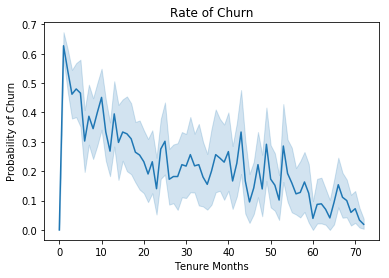

In [49]:
sns.lineplot(x='tenure', y='churn', data=train_df)
plt.ylabel('Probability of Churn')
plt.xlabel('Tenure Months')
plt.title("Rate of Churn")

**Modeling** We've created many different ways of looking at the data through graphs; we are looking for any correlations between the feature and churn rate

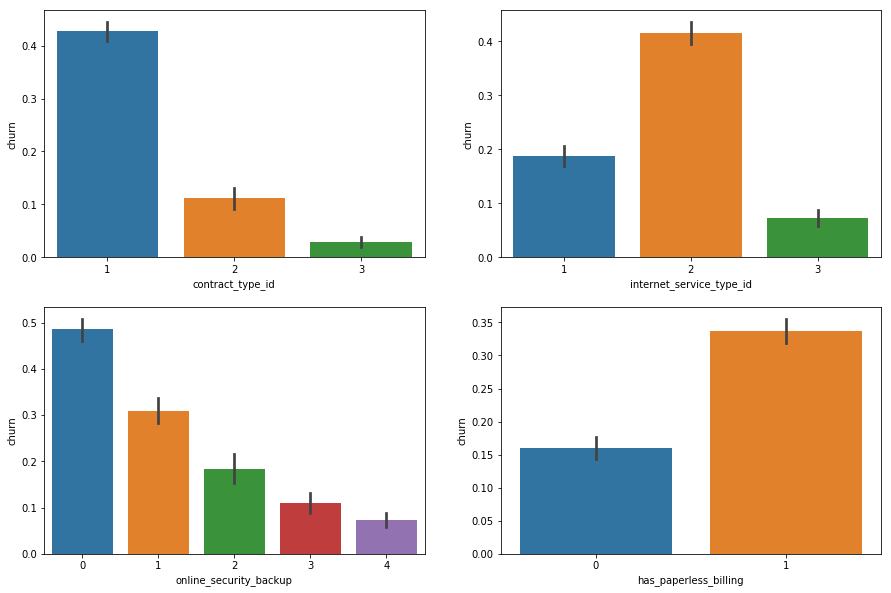

In [324]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

sns.barplot(x='contract_type_id', y='churn', data=train_df,ax=ax[0,0])
sns.barplot(x='internet_service_type_id', y='churn', data=train_df,ax=ax[0,1])
sns.barplot(x='online_security_backup', y='churn', data=train_df,ax=ax[1,0])
sns.barplot(x='has_paperless_billing', y='churn', data=train_df,ax=ax[1,1])

**Answer to Hypothesis:** 
- There is a clear indication where churn starts to happen using our new phone_id variable
- Customers may feel like they might be paying way too much for 1 phone line or multiple lines after around $68.00
- There really isn't a clear indication that customers are churning because of price using the internet service type feature

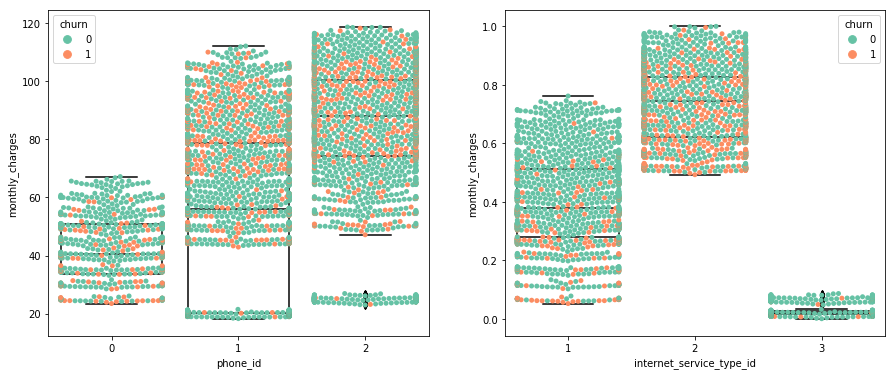

In [51]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.boxplot(x="phone_id", y="monthly_charges", data=df, ax=ax[0],
          showcaps=True,boxprops={'facecolor':'None'}, showfliers=True,whiskerprops={'linewidth':0}, color='Black')
sns.swarmplot(x="phone_id", y="monthly_charges", data=df, ax=ax[0], hue="churn", palette="Set2")

sns.swarmplot(x="internet_service_type_id", y="monthly_charges", data=train_df, ax=ax[1], hue="churn", palette="Set2")
sns.boxplot(x="internet_service_type_id", y="monthly_charges", data=train_df, ax=ax[1],
          showcaps=True,boxprops={'facecolor':'None'}, showfliers=True,whiskerprops={'linewidth':0}, color='Black')

4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

**NEW variables** customers with 'less than one year' and customers with 'more than one year'

In [429]:
train_df['less_than_one'] = train_df['tenure_year'] <= 1
train_df['more_than_one'] = train_df['tenure_year'] > 1

test_df['less_than_one'] = test_df['tenure_year'] <= 1
test_df['more_than_one'] = test_df['tenure_year'] > 1

This graph below shows a tone of information about how much more newer customers churn using the specific internet type

Text(0.5, 0, 'Older than a Year')

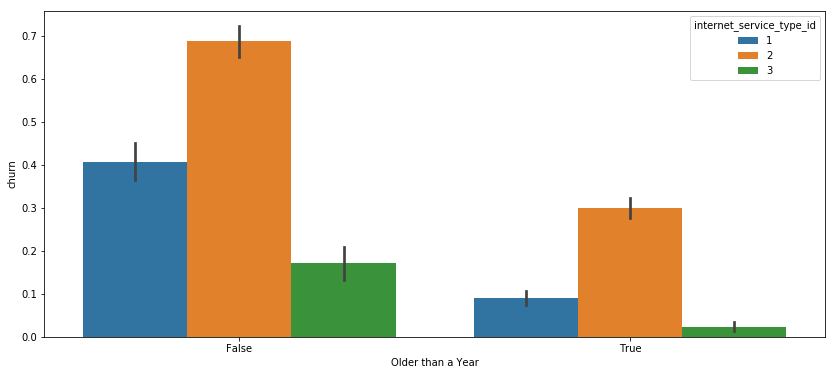

In [433]:
plt.figure(figsize=(14,6))
sns.barplot(x='more_than_one', y='churn', hue='internet_service_type_id', data=train_df)
plt.xlabel('Older than a Year')

This graph below shows a tone of information about how much more newer customers churn using the specific contract type

Text(0.5, 0, 'Older than a Year')

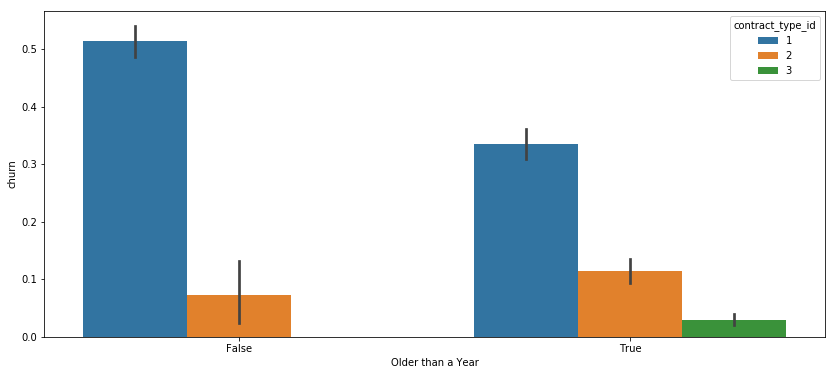

In [432]:
plt.figure(figsize=(14,6))
sns.barplot(x='more_than_one', y='churn', hue='contract_type_id', data=train_df)
plt.xlabel('Older than a Year')

This graph below shows a tone of information about how much more newer customers churn using the specific number of phone lines
- customers with multiple lines and less than a year churn almost 70% of the time!
- customers with no lines and less than a year churn almost 50% of the time!
- The price of having multiple lines is far too high for our customers, likewise is the price for a single line

Text(0.5, 0, 'Older than a Year')

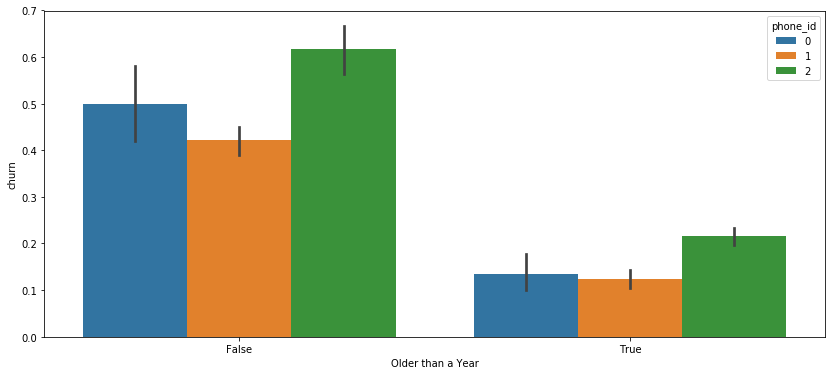

In [434]:
plt.figure(figsize=(14,6))
sns.barplot(x='more_than_one', y='churn', hue='phone_id', data=train_df)
plt.xlabel('Older than a Year')

**Hypothesis:*** Testing to see the difference between entry year customers and post 12 month customer as it relates to churn.

    A large t-score with customers more than 1 year tells us that the groups are different
    A small t-score with customers less than 1 year establishment tells us that the groups are similar

**T-testing Sampling**

In [54]:
sp.stats.ttest_ind(train_df[train_df.tenure_year <= 1].monthly_charges.dropna(), train_df.churn)

Ttest_indResult(statistic=9.830566343480967, pvalue=1.1988936511239781e-22)

In [55]:
sp.stats.ttest_ind(train_df[train_df.tenure_year > 1].monthly_charges.dropna(), train_df.churn)

Ttest_indResult(statistic=27.56732365207348, pvalue=3.546705496180873e-160)

Does the phone_id have an effect on churn?

In [56]:
sp.stats.ttest_ind(train_df.phone_id, train_df.churn)

Ttest_indResult(statistic=96.62523722458897, pvalue=0.0)

Does the internet_service_type_id have an effect on churn?

In [57]:
sp.stats.ttest_ind(train_df.internet_service_type_id, train_df.churn)

Ttest_indResult(statistic=132.78427973501704, pvalue=0.0)

Does the online_security_backup have an effect on churn?

In [58]:
sp.stats.ttest_ind(train_df.online_security_backup, train_df.churn)

Ttest_indResult(statistic=66.03078247291516, pvalue=0.0)

Does the contract_type_id have an effect on churn?

In [59]:
sp.stats.ttest_ind(train_df.contract_type_id, train_df.churn)

Ttest_indResult(statistic=106.0519180040615, pvalue=0.0)

**monthly_charges** can be explained by **internet_service_type** 32% of the time

In [60]:
np.corrcoef(train_df.monthly_charges, train_df.internet_service_type_id)[0, 1]

-0.32367274140588126

**Null Hypotheses:** Monthly charges can not be explained with the features internet service type and phone service type

Draw a nested barplot to show churn for internet_service_type_id and phone_id

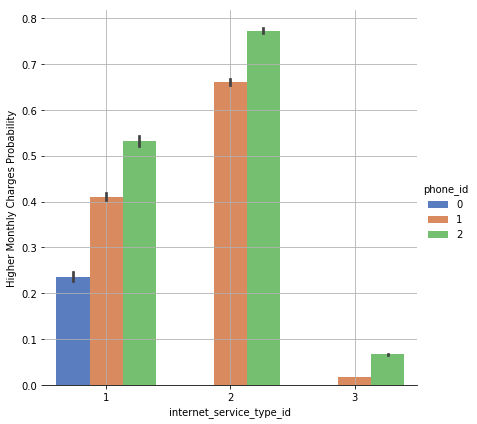

In [61]:
g = sns.catplot(x="internet_service_type_id", y="monthly_charges", hue="phone_id", data=train_df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Higher Monthly Charges Probability")
plt.grid(b = True , which = "major")

**Conlusion:** The graph above shows the probability of higher monthly charges in each case of internet service type (No Internet, DSL, Fiber) and number of phone lines (0, 1, 1+)
- Multiple lines and fiber optic features have customers churning almost 80% of the time!
- Even single lines and a single line have customrs churning almost 70% of the time!

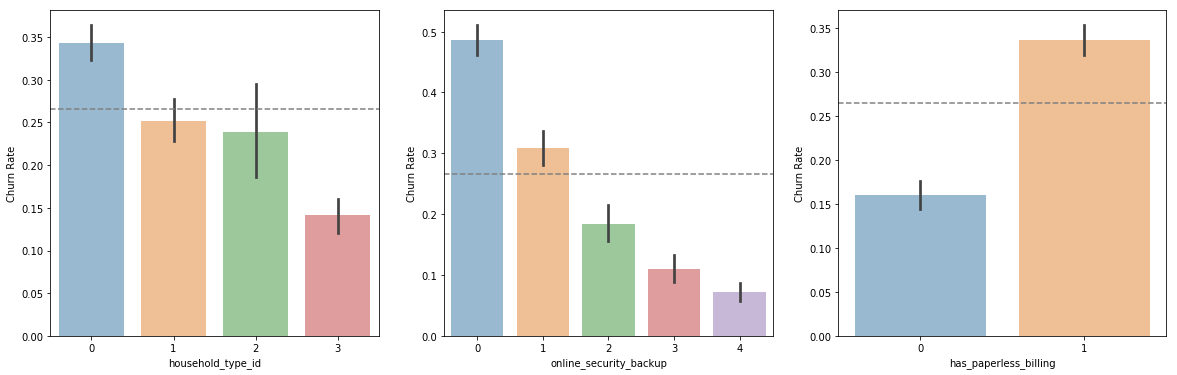

In [62]:
features = ['household_type_id', 'online_security_backup', 'has_paperless_billing']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

**Answer to Hypothesis**
- The three graphs below show the features with the highest correlation to churn rate
- The month to month option produces over a 40% churn rate
- Customers without online security or online backup almost produces a 50% churn rate
- The Fiber Optic customers show the highes churn rate of the internet service types with over 40%

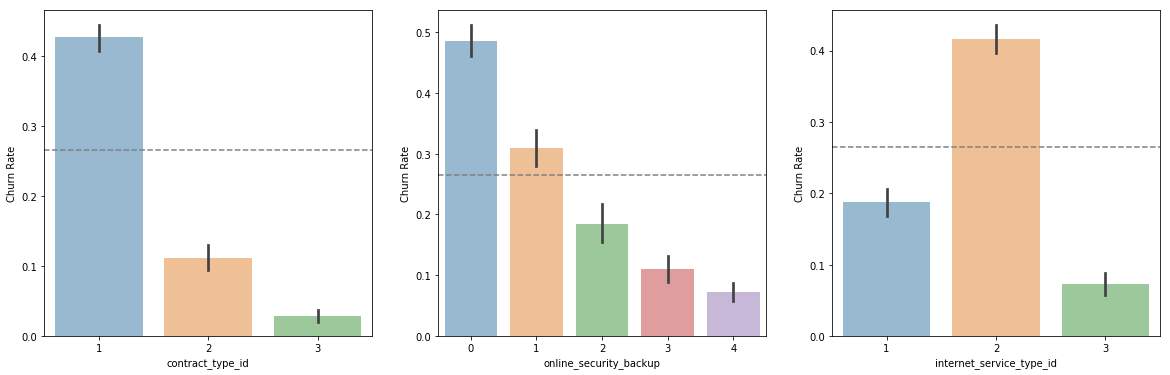

In [325]:
features = ['contract_type_id', 'online_security_backup', 'internet_service_type_id']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

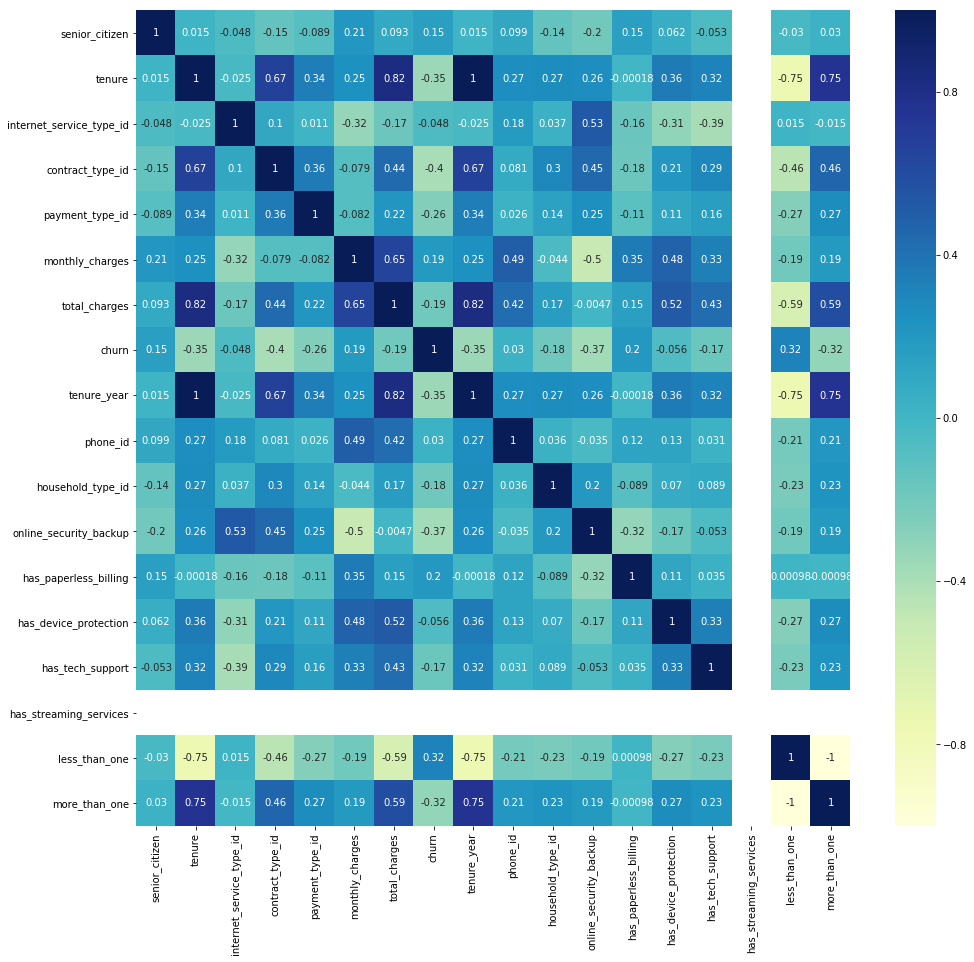

In [64]:
plt.figure(figsize=(16,15))

sns.heatmap(train_df.corr(), annot=True, cmap="YlGnBu")

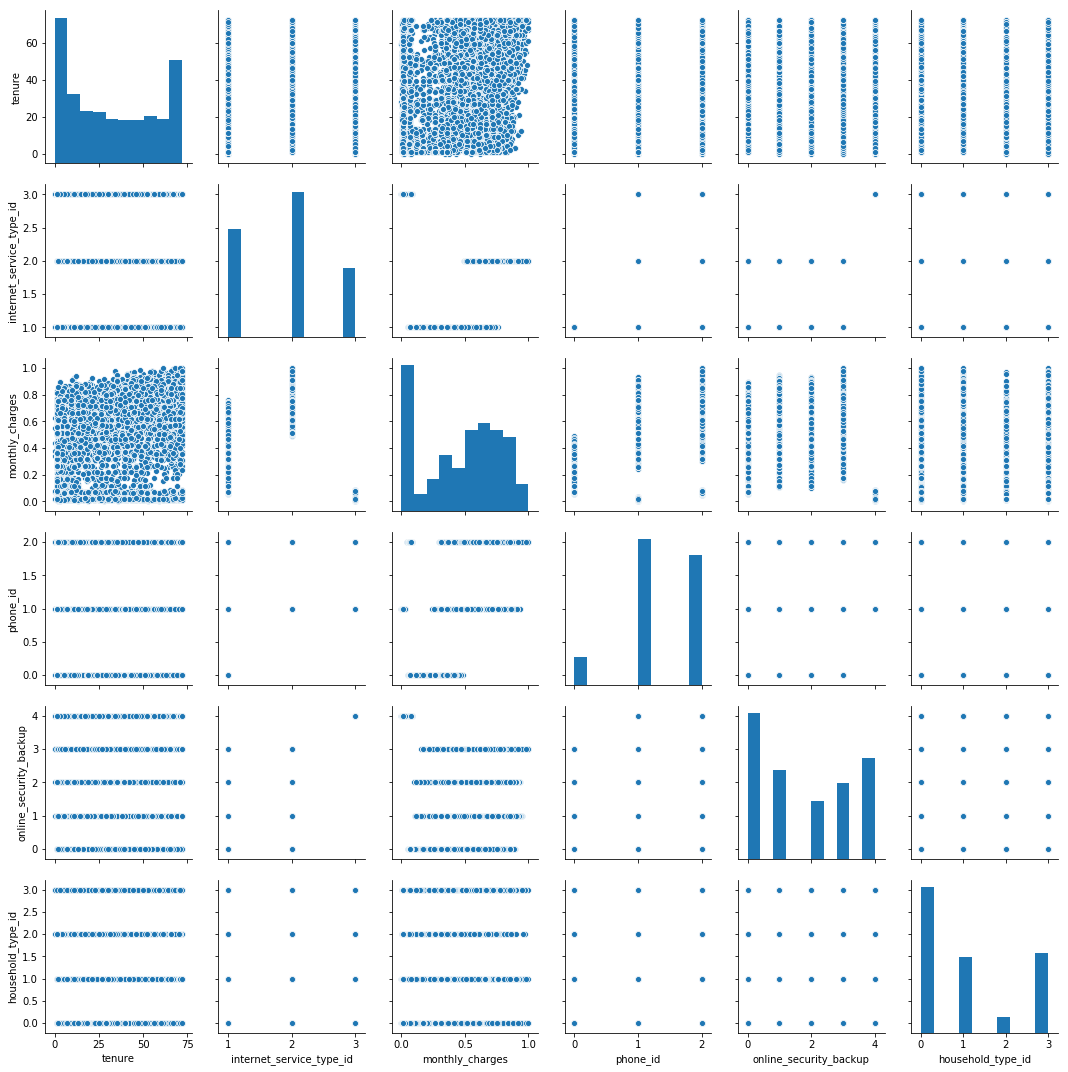

In [67]:
sns.pairplot(train_df[['tenure', 'internet_service_type_id', 
                    'monthly_charges', 'phone_id', 'online_security_backup', 
                    'household_type_id']])

**Realtionship to churn**
1. 2 out of 5 customers are leaving that have a month to month contract regardless of time
2. 7 out of 25 customers with a multiple line phone plan churn
3. 2 out of 5 customers with the fiber optic internet option churn
4. 12 out of 25 customer without online securty or online backup churn
5. 2 out of 5 senior citizens churn
6. 17 out of 50 single member households churn
7. 17 out of 50 customers with paperless billing churn
8. 8 out of 25 customers that do not have device protection churn
9. 1 out of 3 customers without a technical support option churn
10. 1 out of 4 customers with a streaming service churn

**Summary**

Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
- There are multiple features that have a higher probability of churnning: the highest out of the features explored was customers without online security and backup, customers with less than 1 year of tenure, and finally the customers with the fiber optic internet option
- Customers that have phone lines and the fiber optic internet service and less than a year are churning more that 70% of the time

Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
- Yes there is a specific threashold with the phone service monthly price; there is a greater number of churned cusomers above the price of $65.00
- With the internet service type there was not a clear identifier in monthly charge where customers were churnning a little more

If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?
- Month to month customers that churn nearly double the count of customers that have a 1 year contract regardless of tenure
    - 50% of customers churn which have the month to month contract BEFORE their 12th month vs the less than 1 year contract of less than 10%
    - 35% of month to month customers churn AFTER the 12th month mark vs 10% with the 1 year contractors

## Modeling

In [68]:
train_df.columns

Index(['gender', 'senior_citizen', 'tenure', 'internet_service_type_id',
       'contract_type_id', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'tenure_year', 'phone_id',
       'household_type_id', 'online_security_backup', 'has_paperless_billing',
       'has_device_protection', 'has_tech_support', 'has_streaming_services',
       'less_than_one', 'more_than_one'],
      dtype='object')

### Logistic Regression Model

In [456]:
logit = LogisticRegression(dual=True, random_state=123, fit_intercept=True)

In [457]:
logit.fit(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], train_df.churn)

LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [458]:
logit.predict(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                        'monthly_charges', 'internet_service_type_id']])

array([0, 0, 0, ..., 0, 0, 1])

In [459]:
train_df['prediction'] = logit.predict(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                                                 'monthly_charges', 'internet_service_type_id']])

In [460]:
(train_df.churn == train_df.prediction).sum() / train_df.shape[0]

0.7866125760649088

In [461]:
confusion_matrix(train_df.churn, train_df.prediction)

array([[3234,  388],
       [ 664,  644]])

What can we learn from this matrix?

- There are two possible predicted classes: "+" and "-" where "-" is not churn and "+" is churn
- The classifier made a total of 4950 predictions
- Out of those 4950 cases, the classifier predicted "churn" 1052 times, and "not churn" 3898 times.
- In reality, 3622 customers did not churn, and 1308 patients did
- We have an 80% True Positive rate with regards to churn

In [462]:
cm = pd.DataFrame(confusion_matrix(train_df.churn, train_df.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

cm

,Pred -,Pred +
Actual -,3234,388
Actual +,664,644


In [463]:
print(classification_report(train_df.churn, train_df.prediction))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3622
           1       0.62      0.49      0.55      1308

   micro avg       0.79      0.79      0.79      4930
   macro avg       0.73      0.69      0.71      4930
weighted avg       0.78      0.79      0.78      4930



In [464]:
y_pred_proba = logit.predict_proba(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']])

In [465]:
train_df.churn.value_counts()

0    3622
1    1308
Name: churn, dtype: int64

In [466]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                                   'monthly_charges', 'internet_service_type_id']], train_df.churn)))

Accuracy of Logistic Regression classifier on training set: 0.79


### Decision Tree Model

In [309]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123, min_samples_split=4)

In [310]:
clf.fit(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], train_df.churn)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [311]:
y_pred = clf.predict(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']])
y_pred[0:5]
y_pred_proba = clf.predict_proba(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']])

In [320]:
labels = sorted(train_df.churn.unique())

pd.DataFrame(confusion_matrix(train_df.churn, y_pred), index=labels, columns=labels)

,0,1
0,3321,301
1,640,668


In [321]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], train_df.churn)))

Accuracy of Decision Tree classifier on training set: 0.81


In [322]:
confusion_matrix(train_df.churn, y_pred)

array([[3321,  301],
       [ 640,  668]])

In [315]:
print(classification_report(train_df.churn, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3622
           1       0.69      0.51      0.59      1308

   micro avg       0.81      0.81      0.81      4930
   macro avg       0.76      0.71      0.73      4930
weighted avg       0.80      0.81      0.80      4930



In [316]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(test_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], test_df.churn)))

Accuracy of Decision Tree classifier on test set: 0.79


### Random Forest Model

In [232]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [233]:
rf.fit(train_df.drop(columns=['gender','churn','prediction','tenure']), train_df.churn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [234]:
important_features = pd.Series(data=rf.feature_importances_,index=train_df.drop(columns=['gender', 'churn','prediction','tenure']).columns)
important_features.sort_values(ascending=False,inplace=True)
important_features

contract_type_id            0.224473
online_security_backup      0.172304
tenure_year                 0.159784
monthly_charges             0.100314
internet_service_type_id    0.079652
total_charges               0.064733
more_than_one               0.055305
payment_type_id             0.050817
less_than_one               0.048263
has_tech_support            0.013085
has_paperless_billing       0.011444
phone_id                    0.007214
senior_citizen              0.006750
household_type_id           0.004391
has_device_protection       0.001471
has_streaming_services      0.000000
dtype: float64

In [236]:
y_pred = rf.predict(train_df.drop(columns=['gender','churn','prediction','tenure']))
y_pred_proba = rf.predict_proba(train_df.drop(columns=['gender','churn','prediction','tenure']))

In [203]:
y_pred_proba[0:10]

array([[0.9573605 , 0.0426395 ],
       [0.82590421, 0.17409579],
       [0.94317663, 0.05682337],
       [0.98553664, 0.01446336],
       [0.80564519, 0.19435481],
       [0.38077601, 0.61922399],
       [0.52369682, 0.47630318],
       [0.88829405, 0.11170595],
       [0.8665922 , 0.1334078 ],
       [0.77211256, 0.22788744]])

In [204]:
print(confusion_matrix(train_df.churn, y_pred))

[[3373  249]
 [ 714  594]]


In [205]:
print(classification_report(train_df.churn, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3622
           1       0.70      0.45      0.55      1308

   micro avg       0.80      0.80      0.80      4930
   macro avg       0.76      0.69      0.71      4930
weighted avg       0.79      0.80      0.79      4930



In [237]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(train_df.drop(columns=['gender','churn','prediction','tenure']), train_df.churn)))

Accuracy of random forest classifier on training set: 0.80


### KNN model

In [208]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='ball_tree')

In [209]:
knn.fit(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], train_df.churn)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [210]:
y_pred = knn.predict(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']])
y_pred_proba = knn.predict_proba(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']])

In [211]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], train_df.churn)))

Accuracy of KNN classifier on training set: 0.99


In [213]:
print(confusion_matrix(train_df.churn, y_pred))

[[3607   15]
 [  53 1255]]


In [214]:
print(classification_report(train_df.churn, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3622
           1       0.99      0.96      0.97      1308

   micro avg       0.99      0.99      0.99      4930
   macro avg       0.99      0.98      0.98      4930
weighted avg       0.99      0.99      0.99      4930



In [215]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(train_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], train_df.churn)))

Accuracy of KNN classifier on test set: 0.99


In [216]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(knn.score(test_df[['contract_type_id', 'online_security_backup', 'tenure_year', 
                    'monthly_charges', 'internet_service_type_id']], test_df.churn)))

Accuracy of random forest classifier on test set: 0.75


**Evaluation of the models:**
1. Logistic Regression performed better on the test data set; the training model had a 79% churn accuracy and the test data had a 80% churn accuracy.
2. The Decision tree was interesting because normally decision trees are prone to overfitting. The decision tree performed about as good as the linear regression model
3. The Random Forest is a classic overfit but used the random forest important features to build a logistic regression model - it essentially ranked the features from top to bottom which I used to tune the logistic model
4. KNN overfit from the features that brought into the model - which used the features again that came from the important features that the random forest generated

In [467]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(test_df[['contract_type_id', 'online_security_backup', 'tenure_year',
                                   'monthly_charges', 'internet_service_type_id']], test_df.churn)))

Accuracy of Logistic Regression classifier on test set: 0.80


**Summary of Test Model:**
1. The out of sample dataset worked better with the model that was created
2. The training model was binary classification and potentially the test had a lot of 1s, even it it doesn’t know if it’s a 1 or a 0 it could guess
3. The out of sample test could make it seem like there is a high accuracy, further modeling and testing is needed

**Create CSV file with Final Predictions**

In [415]:
df_a = train_df[['customer_id', 'prediction']]
dataset = pd.DataFrame({'Probability of Not Churn':y_pred_proba[:,0],'Probability of Churn':y_pred_proba[:,1]})

In [417]:
df_churn_outcomes = pd.concat([df_a, dataset], axis=1)

In [424]:
df_churn_outcomes.to_csv('project_churn_outcomes', sep='\t', index=False)